In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans

from collections import Counter

import os
%matplotlib inline
from IPython.display import display

pd.set_option('display.max_columns', 500)

In [16]:
kaggle_df3=pd.read_csv('../../../datasets/nyc_taxi_trip_duration/df_after_preprocess.csv').drop(['Unnamed: 0'],1)
#kaggle_df3=pd.read_csv('/nyc_taxi_trip_duration/df_after_preprocess.csv').drop(['Unnamed: 0'],1)

#df_sample=kaggle_df3.sample(50000)

## Train Test split

In [17]:
X=kaggle_df3.select_dtypes(include=[np.number])
X = X.drop(['trip_duration'], axis=1)
#print X.shape

y = np.log1p(kaggle_df3['trip_duration'])

display(X.head(2))

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_cluster,dropoff_cluster,haversine_distance,pickup_weekday,pickup_hour,pickup_month,pickup_day,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,18,3,1.498521,0,17,3,14,48,42,45.0,0.89,0.0,0.0
1,0,1,-73.975090,40.758766,-73.953201,40.765068,0,45,53,1.972206,0,14,3,14,48,42,45.0,0.89,0.0,0.0


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10000)

#print X_train.shape,X_test.shape

In [24]:
X_sample=X_train.iloc[0:200000,:]
y_sample=y_train.iloc[0:200000]

In [25]:
X_sample.shape

(200000, 20)

## Define loss function
#### Root Mean Squared Logarithmic Error

In [21]:
def rmsle_eval(y, y0):
    y0 = y0.get_label()    
    assert len(y) == len(y0)
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

def rmsle_eval_sklearn(y, y0): 
    assert len(y) == len(y0)
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

def rmsle_eval_sklearn2(y, y0): 
    assert len(y) == len(y0)
    return -np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

## Benchmark model

In [8]:
#linear model
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

print 'Root Mean Squared Logarithmic Error:',rmsle_eval_sklearn(y_test, reg.predict(X_test))

Root Mean Squared Logarithmic Error: ('rmsle', 0.074457448651204711)


In [9]:
from sklearn.neighbors import  KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_train,y_train)

print 'Root Mean Squared Logarithmic Error:',rmsle_eval_sklearn(y_test, reg.predict(X_test))

Root Mean Squared Logarithmic Error: ('rmsle', 0.0728812056095266)


In [10]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=10)
reg.fit(X_train,y_train)

print 'Root Mean Squared Logarithmic Error:',rmsle_eval_sklearn(y_test, reg.predict(X_test))

Root Mean Squared Logarithmic Error: ('rmsle', 0.047572052359185185)


## XGBoost training

In [22]:
from sklearn.learning_curve import validation_curve
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import make_scorer

my_scorer=make_scorer(rmsle_eval_sklearn2)

#### validation curve plot

In [48]:
def validation_curve_plot(train_scores, test_scores,param_name,param_range,ylim_low,ylim_high):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    #fig = plt.figure(figsize=(10, 6), dpi=100)
    fig = plt.figure(figsize=(10, 4))

    plt.plot(param_range,
                 train_scores_mean,
                 label="Training score",
                 color="r")

    plt.plot(param_range,
                 test_scores_mean, 
                 label="Cross-validation score",
                 color="g")

    plt.fill_between(param_range, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.2, color="r")

    plt.fill_between(param_range,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.2, color="g")

    plt.axhline(y=1, color='k', ls='dashed')

    plt.title("Validation Curve with XGBoost (eta = 0.1)")
    plt.xlabel(param_name)
    plt.ylabel("Negative RMSLE")
    plt.ylim(ylim_low,ylim_high)
    plt.legend(loc="best")
    plt.show()

    i = np.argmax(test_scores_mean)
    print("Best cross-validation result ({0:.2f}) obtained for {1} {2}".format(test_scores_mean[i], param_range[i],param_name))

#### 1 max_depth

In [53]:
from sklearn.learning_curve import validation_curve
default_params = {
    "objective":"reg:linear",
    "eta":0.1,
    "min_child_weight":30,
    "subsample" : 0.8,
    "colsample_bytree" :0.3,
    "silent":1
}

max_depth_range = np.linspace(1, 100, 5).astype('int')

train_scores1, test_scores1 = validation_curve(
    XGBRegressor(**default_params),
    X_sample, y_sample,
    param_name = 'max_depth',
    param_range = max_depth_range,
    cv=3,
    scoring=my_scorer,
    n_jobs=5
)

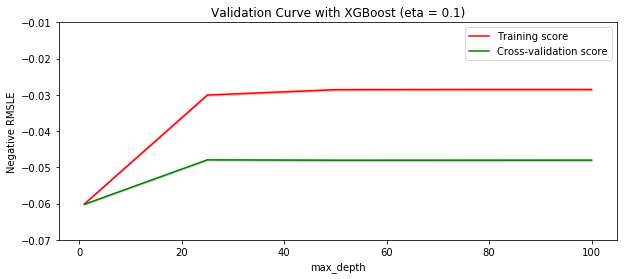

Best cross-validation result (-0.05) obtained for 25 max_depth


In [54]:
validation_curve_plot(train_scores1, test_scores1,'max_depth',max_depth_range,-0.07,-0.01)

#### 2 subsample

In [46]:
default_params = {
    "objective":"reg:linear",
    "eta":0.1,
    "min_child_weight":30,
    "colsample_bytree" :0.3,
    'max_depth':25,
    "silent":1
}

subsample_range = np.linspace(0, 1, 5).astype('float32')

train_scores, test_scores = validation_curve(
    XGBRegressor(**default_params),
    X_sample, y_sample,
    param_name = 'subsample',
    param_range = subsample_range,
    cv=3,
    scoring=my_scorer,
    n_jobs=5
)

In [63]:
np.linspace(0, 1, 5).astype('float32')

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ], dtype=float32)

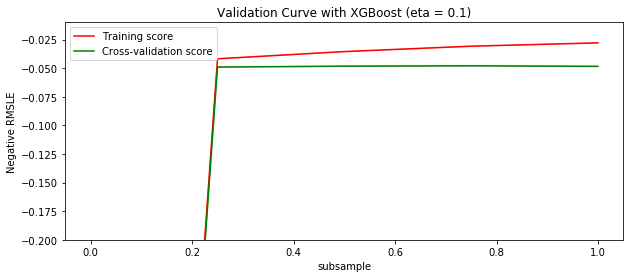

Best cross-validation result (-0.05) obtained for 0.75 subsample


In [52]:
validation_curve_plot(train_scores, test_scores,'subsample',subsample_range,-0.2,-0.01)

#### final training

In [57]:
#Train model
seed=100
num_rounds =500

params = {
    "objective":"reg:linear",
    "eta":0.1,
    "min_child_weight":30,
    "subsample" : 0.75,
    "colsample_bytree" :0.3,
    "silent":1,
    "max_depth": 10
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [58]:
watchlist = [(dtrain, 'train'), (dtest, 'test')]

evals_result = {}

model = xgb.train(params,dtrain, num_rounds, watchlist, 
                      early_stopping_rounds=10, 
                      maximize=False, 
                      verbose_eval=20, 
                      feval=rmsle_eval,
                      evals_result=evals_result)

[0]	train-rmse:5.42728	test-rmse:5.42508	train-rmsle:1.2695	test-rmsle:1.26924
Multiple eval metrics have been passed: 'test-rmsle' will be used for early stopping.

Will train until test-rmsle hasn't improved in 10 rounds.
[20]	train-rmse:0.780639	test-rmse:0.780824	train-rmsle:0.105394	test-rmsle:0.105452
[40]	train-rmse:0.381373	test-rmse:0.385238	train-rmsle:0.052448	test-rmsle:0.053008
[60]	train-rmse:0.351162	test-rmse:0.357287	train-rmsle:0.048898	test-rmsle:0.049764
[80]	train-rmse:0.337955	test-rmse:0.345667	train-rmsle:0.04717	test-rmsle:0.048258
[100]	train-rmse:0.330531	test-rmse:0.339535	train-rmsle:0.046166	test-rmsle:0.047436
[120]	train-rmse:0.325805	test-rmse:0.336084	train-rmsle:0.045522	test-rmsle:0.046971
[140]	train-rmse:0.319492	test-rmse:0.331152	train-rmsle:0.044669	test-rmsle:0.046315
[160]	train-rmse:0.315508	test-rmse:0.328536	train-rmsle:0.044127	test-rmsle:0.045968
[180]	train-rmse:0.311857	test-rmse:0.326134	train-rmsle:0.04363	test-rmsle:0.045647
[200]	tr

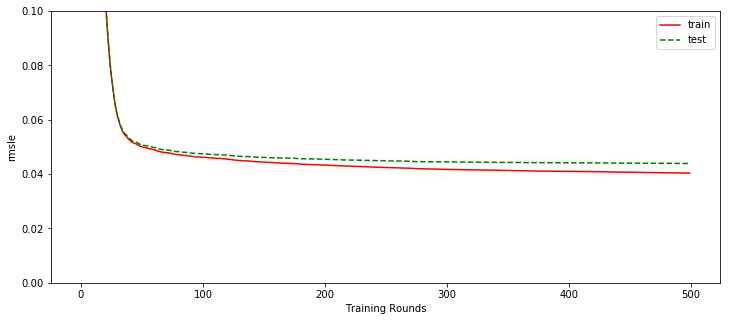

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

rounds=np.arange(0,500)
train_rmsle=evals_result[u'train']['rmsle']
test_rmsle=evals_result[u'test']['rmsle']

plt.figure(figsize=(12,5))
plt.plot(rounds,train_rmsle,'r', label='train')
plt.plot(rounds,test_rmsle,'g--', label='test')

plt.ylim(0,0.1)
plt.xlabel('Training Rounds')
plt.ylabel('rmsle')
plt.legend()
plt.show()

#### feature importance

In [60]:
def plot_importances(clf):
    importances = clf.get_fscore()
    importances = sorted(importances.items(), key=lambda x: x[1])
    x = list(zip(*importances))[0]
    y = list(zip(*importances))[1]
    x_pos = np.arange(len(x)) 
    plt.figure(figsize=(10,5))
    plt.title('Feature importances')
    plt.barh(range(len(y)), y, align='center')
    plt.yticks(range(len(y)), x)
    plt.ylim([-1, len(importances)])
    plt.xlabel('F score')
    plt.show()

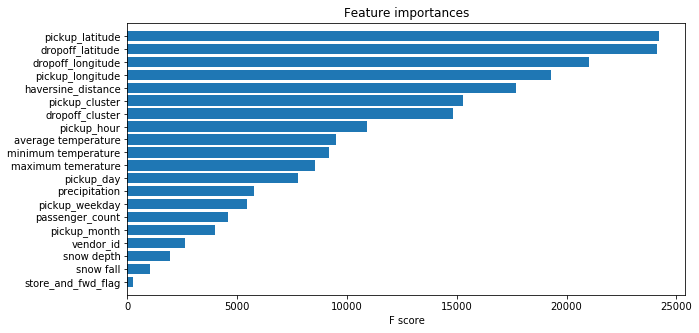

In [61]:
plot_importances(model)

#### cross validation

In [68]:
import pandas as pd
from IPython.display import display

num_rounds =500 # how many estimators
hist = xgb.cv(params, dtrain, num_rounds, nfold=3,
              stratified=True, feval=rmsle_eval,verbose_eval=True, seed=seed)

[0]	train-rmse:5.42708+0.00145421	train-rmsle:1.26947+0.000119455	test-rmse:5.42709+0.00344939	test-rmsle:1.26948+0.000335919
[1]	train-rmse:4.89043+0.00195377	train-rmsle:1.04157+0.000108266	test-rmse:4.8905+0.00434721	test-rmsle:1.0416+0.000389312
[2]	train-rmse:4.40712+0.000447638	train-rmsle:0.873267+5.5259e-05	test-rmse:4.40718+0.00469435	test-rmsle:0.873284+0.000405108
[3]	train-rmse:3.97283+0.00209811	train-rmsle:0.742986+0.000126771	test-rmse:3.97282+0.00421688	test-rmsle:0.742983+0.000416711
[4]	train-rmse:3.58109+0.000769094	train-rmsle:0.638727+6.63643e-05	test-rmse:3.58108+0.00356321	test-rmsle:0.638723+0.000361076
[5]	train-rmse:3.23112+0.00127042	train-rmsle:0.553628+0.000122497	test-rmse:3.23118+0.00434888	test-rmsle:0.55364+0.00040499
[6]	train-rmse:2.91701+0.00218365	train-rmsle:0.482983+0.00016557	test-rmse:2.91709+0.00454631	test-rmsle:0.482996+0.000426554
[7]	train-rmse:2.63441+0.00192462	train-rmsle:0.423518+0.000102948	test-rmse:2.63442+0.00233805	test-rmsle:0.423

[63]	train-rmse:0.34487+0.00148397	train-rmsle:0.048117+0.000211737	test-rmse:0.352516+0.00112251	test-rmsle:0.0491903+0.00012406
[64]	train-rmse:0.344165+0.00137223	train-rmsle:0.0480277+0.000198061	test-rmse:0.351921+0.000948691	test-rmsle:0.0491153+0.000102412
[65]	train-rmse:0.34344+0.0012392	train-rmsle:0.0479353+0.000185462	test-rmse:0.351319+0.000627879	test-rmsle:0.04904+5.97551e-05
[66]	train-rmse:0.343037+0.00132997	train-rmsle:0.0478813+0.000197471	test-rmse:0.351005+0.000850904	test-rmsle:0.0489987+9.59074e-05
[67]	train-rmse:0.342116+0.00167204	train-rmsle:0.0477643+0.000239542	test-rmse:0.350208+0.00137328	test-rmsle:0.0488987+0.000164642
[68]	train-rmse:0.341441+0.00146144	train-rmsle:0.0476737+0.000215726	test-rmse:0.349667+0.00115966	test-rmsle:0.0488273+0.000139481
[69]	train-rmse:0.340836+0.00135372	train-rmsle:0.0475967+0.000202814	test-rmse:0.349145+0.00128692	test-rmsle:0.0487613+0.000156082
[70]	train-rmse:0.340592+0.00145486	train-rmsle:0.0475653+0.000218266	tes

[125]	train-rmse:0.31888+0.000567139	train-rmsle:0.0445853+8.92089e-05	test-rmse:0.332599+0.00099242	test-rmsle:0.0465237+0.000119134
[126]	train-rmse:0.31868+0.000592261	train-rmsle:0.0445593+9.30424e-05	test-rmse:0.33244+0.000929936	test-rmsle:0.0465033+0.000112269
[127]	train-rmse:0.318491+0.000518795	train-rmsle:0.0445337+8.36434e-05	test-rmse:0.33231+0.000960429	test-rmsle:0.0464857+0.000118604
[128]	train-rmse:0.31833+0.000531414	train-rmsle:0.04451+8.54166e-05	test-rmse:0.332242+0.000956267	test-rmsle:0.0464757+0.000118551
[129]	train-rmse:0.318229+0.000501505	train-rmsle:0.044497+8.06267e-05	test-rmse:0.33218+0.000999281	test-rmsle:0.0464677+0.000122568
[130]	train-rmse:0.317819+0.000394399	train-rmsle:0.044441+6.64279e-05	test-rmse:0.331876+0.00109158	test-rmsle:0.0464277+0.000136863
[131]	train-rmse:0.31762+0.000307218	train-rmsle:0.0444147+5.53795e-05	test-rmse:0.331752+0.00116145	test-rmsle:0.046411+0.000146672
[132]	train-rmse:0.317368+0.000328102	train-rmsle:0.044382+5.78

[187]	train-rmse:0.307562+0.000308464	train-rmsle:0.043036+4.6483e-05	test-rmse:0.325459+0.00145	test-rmsle:0.0455687+0.000198411
[188]	train-rmse:0.307494+0.000316216	train-rmsle:0.043026+4.82494e-05	test-rmse:0.325439+0.00144287	test-rmsle:0.0455657+0.000197761
[189]	train-rmse:0.307308+0.0002617	train-rmsle:0.043+4.05545e-05	test-rmse:0.325333+0.00148776	test-rmsle:0.045551+0.000203648
[190]	train-rmse:0.307216+0.000226282	train-rmsle:0.0429873+3.5046e-05	test-rmse:0.325288+0.00142662	test-rmsle:0.045545+0.000195163
[191]	train-rmse:0.307113+0.000282867	train-rmsle:0.0429723+4.30839e-05	test-rmse:0.325257+0.0014284	test-rmsle:0.0455407+0.000195432
[192]	train-rmse:0.307041+0.000299916	train-rmsle:0.0429623+4.47313e-05	test-rmse:0.32522+0.00142459	test-rmsle:0.045536+0.000195271
[193]	train-rmse:0.306985+0.000326735	train-rmsle:0.0429543+4.75908e-05	test-rmse:0.325205+0.00143274	test-rmsle:0.0455337+0.000195585
[194]	train-rmse:0.306862+0.000440728	train-rmsle:0.0429373+6.42409e-05	t

[249]	train-rmse:0.299452+0.000922163	train-rmsle:0.0419137+0.000139093	test-rmse:0.320794+0.00165354	test-rmsle:0.044938+0.000232475
[250]	train-rmse:0.299239+0.00105709	train-rmsle:0.041883+0.000158196	test-rmse:0.320644+0.00169537	test-rmsle:0.0449167+0.00023929
[251]	train-rmse:0.299189+0.00109908	train-rmsle:0.041876+0.000163911	test-rmse:0.320624+0.00170523	test-rmsle:0.044914+0.000241082
[252]	train-rmse:0.299156+0.0011087	train-rmsle:0.041871+0.000165966	test-rmse:0.320619+0.00170806	test-rmsle:0.0449133+0.000240998
[253]	train-rmse:0.299115+0.00110611	train-rmsle:0.041865+0.000165604	test-rmse:0.320611+0.00171183	test-rmsle:0.044912+0.000242162
[254]	train-rmse:0.29907+0.0011063	train-rmsle:0.041859+0.000165604	test-rmse:0.320591+0.00172306	test-rmsle:0.0449097+0.000243327
[255]	train-rmse:0.299027+0.00114695	train-rmsle:0.0418537+0.000171039	test-rmse:0.320571+0.00173493	test-rmsle:0.0449073+0.000244775
[256]	train-rmse:0.29897+0.00116839	train-rmsle:0.0418457+0.000173935	tes

[311]	train-rmse:0.293959+0.00118594	train-rmsle:0.0411473+0.000183707	test-rmse:0.317999+0.00161571	test-rmsle:0.0445593+0.000228152
[312]	train-rmse:0.293827+0.00116748	train-rmsle:0.041129+0.00018122	test-rmse:0.317934+0.00159062	test-rmsle:0.04455+0.000224234
[313]	train-rmse:0.293743+0.00119909	train-rmsle:0.0411167+0.000185683	test-rmse:0.317907+0.00162681	test-rmsle:0.0445463+0.000229774
[314]	train-rmse:0.2937+0.00120164	train-rmsle:0.0411113+0.000185949	test-rmse:0.317896+0.00162541	test-rmsle:0.0445447+0.000229692
[315]	train-rmse:0.293606+0.00118121	train-rmsle:0.0410983+0.000183823	test-rmse:0.317849+0.00161142	test-rmsle:0.044539+0.000228241
[316]	train-rmse:0.293552+0.00117677	train-rmsle:0.0410907+0.000183598	test-rmse:0.317834+0.00159344	test-rmsle:0.044537+0.00022557
[317]	train-rmse:0.293528+0.00115891	train-rmsle:0.0410873+0.000180485	test-rmse:0.31782+0.00159878	test-rmsle:0.044535+0.000226111
[318]	train-rmse:0.293477+0.00112594	train-rmsle:0.0410803+0.000176441	te

[373]	train-rmse:0.289682+0.000857224	train-rmsle:0.040539+0.000137799	test-rmse:0.316273+0.00154021	test-rmsle:0.0443197+0.000216039
[374]	train-rmse:0.289621+0.000852542	train-rmsle:0.0405307+0.000137245	test-rmse:0.316236+0.00155792	test-rmsle:0.0443147+0.00021804
[375]	train-rmse:0.289542+0.000798881	train-rmsle:0.0405183+0.00012895	test-rmse:0.316207+0.00157326	test-rmsle:0.0443103+0.000219541
[376]	train-rmse:0.289507+0.000773691	train-rmsle:0.040514+0.000125414	test-rmse:0.316196+0.00157996	test-rmsle:0.0443087+0.000220397
[377]	train-rmse:0.289463+0.000769174	train-rmsle:0.0405077+0.000124807	test-rmse:0.316188+0.00156874	test-rmsle:0.0443073+0.000218532
[378]	train-rmse:0.289242+0.000676525	train-rmsle:0.0404763+0.000112678	test-rmse:0.316032+0.00162281	test-rmsle:0.0442853+0.000225188
[379]	train-rmse:0.289169+0.000682344	train-rmsle:0.0404667+0.000113067	test-rmse:0.315984+0.00165686	test-rmsle:0.044279+0.000229475
[380]	train-rmse:0.289098+0.000700493	train-rmsle:0.0404563+

[435]	train-rmse:0.286342+0.00096444	train-rmsle:0.0400573+0.00015407	test-rmse:0.315131+0.00173028	test-rmsle:0.044159+0.000242697
[436]	train-rmse:0.286309+0.000991636	train-rmsle:0.0400517+0.00015838	test-rmse:0.315131+0.00172965	test-rmsle:0.0441587+0.000242994
[437]	train-rmse:0.286285+0.000997454	train-rmsle:0.040049+0.00015915	test-rmse:0.315125+0.00173536	test-rmsle:0.044158+0.000244223
[438]	train-rmse:0.286231+0.00105922	train-rmsle:0.0400417+0.000168066	test-rmse:0.315099+0.00175481	test-rmsle:0.0441547+0.000246458
[439]	train-rmse:0.286191+0.00106538	train-rmsle:0.040036+0.000169005	test-rmse:0.315094+0.00176193	test-rmsle:0.0441537+0.000247851
[440]	train-rmse:0.286164+0.0010684	train-rmsle:0.0400323+0.000169065	test-rmse:0.315089+0.00176708	test-rmsle:0.044153+0.000248316
[441]	train-rmse:0.28611+0.00106681	train-rmsle:0.0400247+0.000169148	test-rmse:0.315075+0.00174218	test-rmsle:0.0441517+0.000244925
[442]	train-rmse:0.286075+0.00106821	train-rmsle:0.0400197+0.000169148

[497]	train-rmse:0.28336+0.00133198	train-rmsle:0.039629+0.000204462	test-rmse:0.314261+0.00177074	test-rmsle:0.044038+0.000249501
[498]	train-rmse:0.283337+0.00132729	train-rmsle:0.0396253+0.000203709	test-rmse:0.314257+0.00177267	test-rmsle:0.0440373+0.00024996
[499]	train-rmse:0.283311+0.00131497	train-rmsle:0.0396217+0.000202493	test-rmse:0.314255+0.00177154	test-rmsle:0.044037+0.00024932


In [71]:
hist.tail(5)

,test-rmse-mean,test-rmse-std,test-rmsle-mean,test-rmsle-std,train-rmse-mean,train-rmse-std,train-rmsle-mean,train-rmsle-std
495,0.314273,0.001759,0.044039,0.000248,0.283434,0.001273,0.039640,0.000196
496,0.314270,0.001763,0.044039,0.000249,0.283399,0.001296,0.039634,0.000200
497,0.314261,0.001771,0.044038,0.000250,0.283360,0.001332,0.039629,0.000204
498,0.314257,0.001773,0.044037,0.000250,0.283337,0.001327,0.039625,0.000204
499,0.314255,0.001772,0.044037,0.000249,0.283311,0.001315,0.039622,0.000202


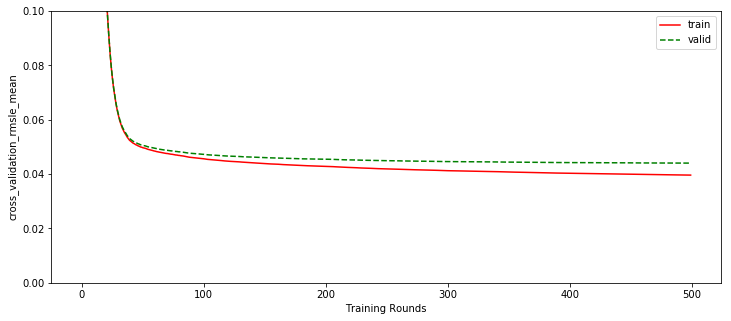

In [69]:
rounds=np.arange(0,500)
train_rmsle=hist['train-rmsle-mean']
test_rmsle=hist['test-rmsle-mean']

plt.figure(figsize=(12,5))
plt.plot(rounds,train_rmsle,'r', label='train')
plt.plot(rounds,test_rmsle,'g--', label='valid')

plt.ylim(0,0.1)
plt.xlabel('Training Rounds')
plt.ylabel('cross_validation_rmsle_mean')
plt.legend()
plt.show()